## ARMA Modeling: Forecasting

**Functions**

`tsa.SARIMAX.forecast`

### Exercise 70
Produce 1-step forecasts from your preferred model in the previous exercise, as well
as a random-walk model. 

1. Are the forecasts objectively accurate?
2. Compare these forecasts to the random walk models using MSE and MAE.

**Note**: Use 50% of the sample to estimate the model and 50% to evaluate it.

In [1]:
import pandas as pd

data = pd.read_hdf("data/term-premium.h5", "term_premium")
term = data["TERM"]

In [2]:
import statsmodels.tsa.api as tsa

nobs = term.shape[0]
half = nobs // 2
mod = tsa.SARIMAX(term.iloc[:half], order=(1, 0, 1), trend="c")
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TERM   No. Observations:                  410
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -72.976
Date:                Wed, 22 Sep 2021   AIC                            153.952
Time:                        11:06:14   BIC                            170.016
Sample:                    04-01-1953   HQIC                           160.307
                         - 05-01-1987                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0577      0.022      2.648      0.008       0.015       0.100
ar.L1          0.8955      0.016     54.356      0.000       0.863       0.928
ma.L1          0.4603      0.020     23.094      0.000       0.421       0.499
sigma2         0.0831      0.003     26.895      0.000       0.077       0.089
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):               952.11
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               6.67   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [3]:
mod = tsa.statespace.SARIMAX(term, order=(1, 0, 1), trend="c")
forecast_res = mod.filter(res.params)

fcast = forecast_res.predict()

errors = term - fcast
oos_errors = errors.iloc[half:]

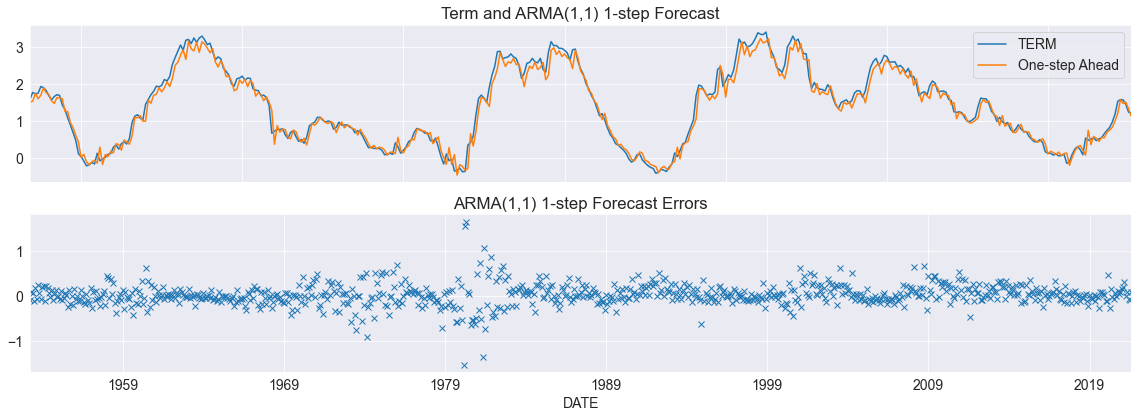

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=14)

both = pd.concat([term, fcast], axis=1)
both.columns = ["TERM", "One-step Ahead"]
both_oos = both.iloc[half:]
fig, axes = plt.subplots(2, 1)
both_oos.plot.line(ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel("")
axes[0].set_title("Term and ARMA(1,1) 1-step Forecast")
errors = both.TERM - both["One-step Ahead"]
errors.plot.line(ax=axes[1], linestyle="none", marker="x")
axes[1].set_title("ARMA(1,1) 1-step Forecast Errors")
fig.tight_layout(pad=1.0)

In [5]:
import statsmodels.api as sm

oos_fcast = sm.add_constant(fcast.iloc[half:])
oos_fcast.columns = ["Const", "Forecast"]
res = sm.OLS(oos_errors, oos_fcast).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     42.93
Date:                Wed, 22 Sep 2021   Prob (F-statistic):           1.71e-10
Time:                        11:06:15   Log-Likelihood:                 151.94
No. Observations:                 411   AIC:                            -299.9
Df Residuals:                     409   BIC:                            -291.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const         -0.0154      0.014     -1.093      0.275      -0.043       0.012
Forecast       0.0563      0.009      6.552      0.000       0.039       0.073
==============================================================================
Omnibus:                       27.734   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.423
Skew:                           0.357   Prob(JB):                     7.57e-14
Kurtosis:                       4.738   Cond. No.                         3.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
import numpy as np

r_matrix = np.eye(2)
res.wald_test(r_matrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[47.5346201]]), p=2.7426560076658914e-19, df_denom=409, df_num=2>

In [7]:
rw_forecast = term.shift(1)
both = pd.concat([term, rw_forecast], axis=1)
rw_error = term - rw_forecast
rw_oos_error = rw_error.iloc[half:]
rw_forecast = sm.add_constant(rw_forecast)
rw_forecast = rw_forecast.iloc[half:]
rw_forecast.columns = ["Const", "One-step RW Forecast"]
res = sm.OLS(rw_oos_error, rw_forecast).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TERM   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.979
Date:                Wed, 22 Sep 2021   Prob (F-statistic):             0.0851
Time:                        11:06:15   Log-Likelihood:                 134.65
No. Observations:                 411   AIC:                            -265.3
Df Residuals:                     409   BIC:                            -257.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Const                    0.0192      0.015      1.322      0.187      -0.009       0.048
One-step RW Forecast    -0.0144      0.008     -1.726      0.085      -0.031       0.002
==============================================================================
Omnibus:                       40.692   Durbin-Watson:                   1.410
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.826
Skew:                           0.483   Prob(JB):                     2.85e-23
Kurtosis:                       5.265   Cond. No.                         3.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
res.wald_test(r_matrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1.4959122]]), p=0.2252673275161235, df_denom=409, df_num=2>

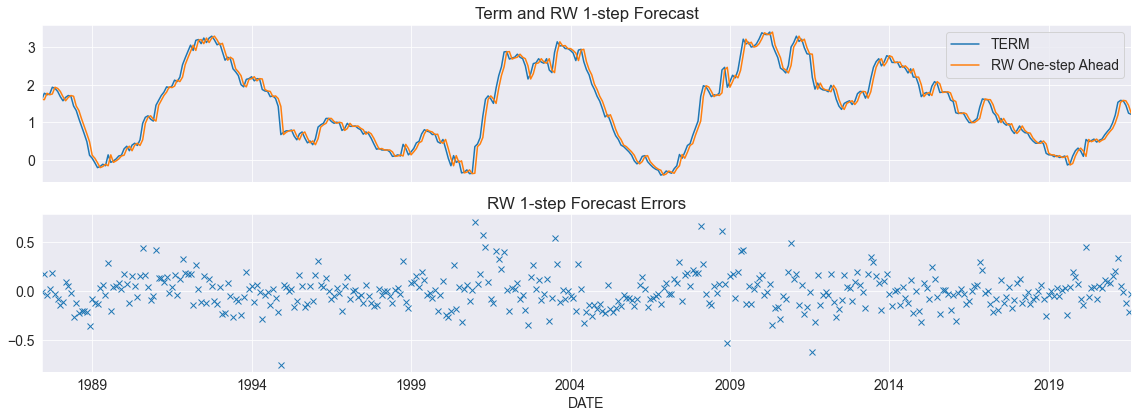

In [9]:
plt.rc("figure", figsize=(16, 6))

both.columns = ["TERM", "RW One-step Ahead"]
both_oos = both.iloc[half:]
fig, axes = plt.subplots(2, 1)
both_oos.plot.line(ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel("")
axes[0].set_title("Term and RW 1-step Forecast")

errors = rw_oos_error
errors.plot.line(ax=axes[1], linestyle="none", marker="x")
axes[1].set_title("RW 1-step Forecast Errors")
fig.tight_layout(pad=1.0)

### Exercise 71

Produce 3-step forecasts from the models selected in the previous exercises as well as a random walk model.

1. Compare these forecasts to the random walk models using MSE and MAE.


In [10]:
nobs = term.shape[0]
half = nobs // 2
mod = tsa.SARIMAX(term.iloc[:half], order=(1, 0, 1), trend="c")
res = mod.fit()
res.summary()

mod = tsa.statespace.SARIMAX(term, order=(1, 0, 1), trend="c")
forecast_res = mod.filter(res.params)

In [11]:
three_step = {}
for t in range(half, nobs):
    fcasts = forecast_res.predict(t, t + 2, dynamic=True)
    key = fcasts.index[-1]
    value = fcasts.iloc[-1]
    three_step[key] = value
three_step = pd.Series(three_step)

In [12]:
three_step_errors = term - three_step
three_step_errors = three_step_errors.dropna()
three_step_errors

1987-08-01    0.409610
1987-09-01    0.412042
1987-10-01    0.415291
1987-11-01    0.510137
1987-12-01    0.350927
                ...   
2021-04-01    0.667667
2021-05-01    0.490005
2021-06-01    0.077502
2021-07-01   -0.052228
2021-08-01   -0.108302
Length: 409, dtype: float64

In [13]:
three_step_rw = term.shift(3)
three_step_rw_errors = term - three_step_rw
three_step_rw_errors = three_step_rw_errors.iloc[half:]

In [14]:
errors = pd.DataFrame({"ARMA": three_step_errors, "RW": three_step_rw_errors}).dropna()
pd.DataFrame([(errors ** 2).mean(), errors.abs().mean()], index=["MSE", "MAE"])

,ARMA,RW
MSE,0.205586,0.131716
MAE,0.346986,0.278337


In [15]:
d = errors["ARMA"] ** 2 - errors["RW"] ** 2
x = np.ones_like(d)
maxlags = int(d.shape[0] ** (1 / 3))
res = sm.OLS(d, x).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 22 Sep 2021   Prob (F-statistic):                nan
Time:                        11:06:16   Log-Likelihood:                -9.5112
No. Observations:                 409   AIC:                             21.02
Df Residuals:                     408   BIC:                             25.04
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0739      0.025      2.970      0.003       0.025       0.123
==============================================================================
Omnibus:                       91.427   Durbin-Watson:                   0.449
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.927
Skew:                           1.095   Prob(JB):                     1.95e-50
Kurtosis:                       5.939   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
"""

In [16]:
d = errors["ARMA"].abs() - errors["RW"].abs()
res = sm.OLS(d, x).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 22 Sep 2021   Prob (F-statistic):                nan
Time:                        11:06:16   Log-Likelihood:                -42.596
No. Observations:                 409   AIC:                             87.19
Df Residuals:                     408   BIC:                             91.21
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0686      0.026      2.635      0.008       0.018       0.120
==============================================================================
Omnibus:                        0.660   Durbin-Watson:                   0.544
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.695
Skew:                           0.096   Prob(JB):                        0.706
Kurtosis:                       2.939   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
"""